In [1]:
import os
import time
import cv2
import numpy as np
import torch
import torchvision
import torch.optim as optim

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
from model import Net

net = Net()
net.cuda()
print(net)

Net(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(

In [3]:
import dataset

train_loader, val_loader = dataset.create_loaders(val_percent = 20, batch_size = 10)


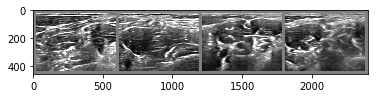

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4], nrow=4,padding=20))


In [5]:
def dice_coef(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (torch.sum(y_true) + torch.sum(y_pred) + 1.)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return (intersection + 1.) / (torch.sum(y_true) + torch.sum(y_pred) - intersection + 1.)

def falsepos(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return torch.sum(y_pred) - intersection

def falseneg(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return torch.sum(y_true) - intersection

def precision(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return intersection / (torch.sum(y_pred) + 1.)

def recall(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return intersection / (torch.sum(y_true) + 1.)

def fscore(y_true, y_pred):
    presci = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*(presci * rec)/(presci + rec)

def weighted_fscore_loss(preci_weight, recall_weight):
    def fscore_loss(y_true, y_pred):
        presci = precision(y_true, y_pred)
        rec = recall(y_true, y_pred)
        return -(1+1)*(presci * rec)/(1*presci + rec)
    return fscore_loss

In [6]:
learning_rate = 1e-5
fscore_weights = (1,1)

criterion = weighted_fscore_loss(*fscore_weights)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
measures = {'dice_coeff':dice_coef, 
            'iou':iou, 
            'fp': falsepos, 
            'fn': falseneg, 
            'precision': precision, 
            'recall': recall, 
            'fscore': fscore }


In [7]:
import train
measurement_log = []
for epoch in range(10):
    measurements = train.fit(net, train_loader, val_loader, criterion, optimizer, lrscheduler, measures, epoch)
    measurement_log.append(measurements)
    print("Epoch: %d: " % epoch, end='')
    for k,v in measurements.items():
        print(" {}:{:.5f}".format(k,v), end=',')
    print()

epoch 0: train-loss=-0.15862, val-loss=-0.40964, new_lr=0.00001
Epoch: 0:  dice_coeff:0.40965, iou:0.25887, fp:37837.06384, fn:58825.80607, precision:0.47341, recall:0.37425, fscore:0.40964, train_loss:-0.15862, val_loss:-0.40964,
epoch 1: train-loss=-0.52101, val-loss=-0.57607, new_lr=0.00001
Epoch: 1:  dice_coeff:0.57608, iou:0.40628, fp:31224.66532, fn:27467.07446, precision:0.56495, recall:0.59869, fscore:0.57607, train_loss:-0.52101, val_loss:-0.57607,
epoch 2: train-loss=-0.60436, val-loss=-0.61727, new_lr=0.00001
Epoch: 2:  dice_coeff:0.61728, iou:0.44779, fp:25777.67603, fn:30463.14185, precision:0.64059, recall:0.60370, fscore:0.61727, train_loss:-0.60436, val_loss:-0.61727,
epoch 3: train-loss=-0.64340, val-loss=-0.63761, new_lr=0.00001
Epoch: 3:  dice_coeff:0.63762, iou:0.46979, fp:29285.48275, fn:18170.97298, precision:0.59155, recall:0.70284, fscore:0.63761, train_loss:-0.64340, val_loss:-0.63761,
epoch 4: train-loss=-0.66813, val-loss=-0.65868, new_lr=0.00001
Epoch: 4:  d

In [8]:
timestamp = time.strftime('%m%d%H%M')
# write out weights
torch.save(net.state_dict(), './ultrasound_%s.pth' % timestamp)

# write out log
with open('./log_%s.txt' % timestamp, 'w') as f:
    f.write('%s\n' % time.strftime('%m-%d %H:%M'))
    f.write('optimizer: %s\n' % type(optimizer).__name__)
    f.write('scheduler: %s\n' % type(lrscheduler).__name__)
    f.write('learning_rate: %.6f\n' % learning_rate)
    f.write('fscore_weights: preci:%d, recall:%d\n' % fscore_weights)
    f.write('\n')
    
    f.write("Epoch: %d\n" % epoch)
    for k,v in measurements.items():
        f.write("{}:{:.5f}\t".format(k,v))
    f.write('\n')
    f.close()

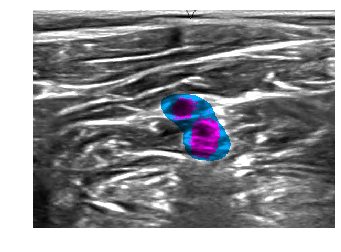

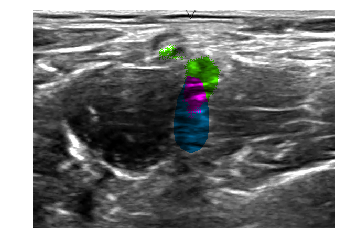

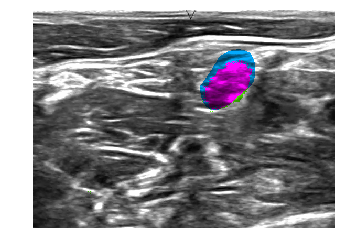

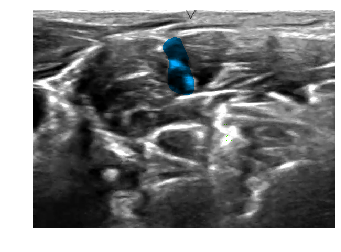

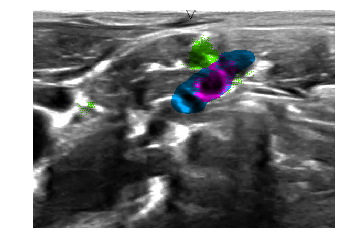

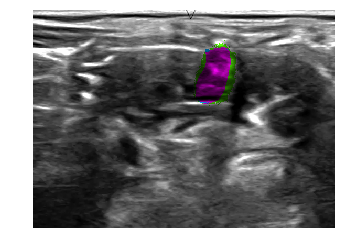

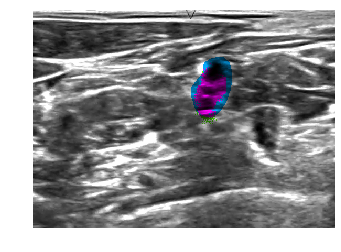

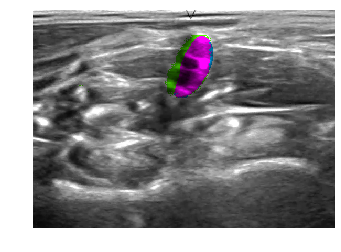

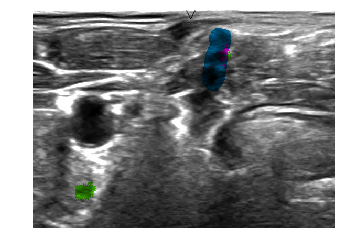

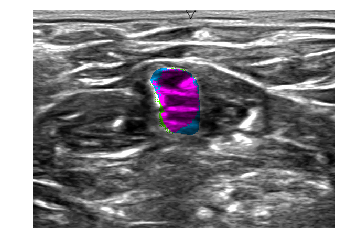

In [88]:
IMAGE_HT = 416
IMAGE_WD = 576

dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.cuda()
output = net(images)

os.mkdir('./output_%s'%timestamp)

for idx in range(10):
    x, y, label = images[idx], output[idx], labels[idx]
    
    y = y.reshape(IMAGE_HT, IMAGE_WD).cpu().detach().numpy()
    label = label.reshape(IMAGE_HT, IMAGE_WD).cpu().detach().numpy()

    # convert image to HSV for annotations
    img = x.cpu().detach().numpy()
    img = (img + 1) * 127
    img = img.astype(np.uint8)
    img = np.dstack((img[0,:,:], img[1,:,:], img[2,:,:]))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # apply prediction and label markings
    h = img[:,:,0]
    s = img[:,:,1]
    h[y > .75] += 50 # GREEN
    s[y > .75] = 250
    h[label > .75] += 100 # BLUE
    s[label > .75] = 250

    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    
    cv2.imwrite('./output_%s/%d.jpg'%(timestamp,idx), img)
    
    plt.figure()
    plt.axis('off')
    plt.imshow(img)
